# Problem C: Prediction of Traffic Flow based on Burgers’ Equation Model
Burgers' equation is a mathematical model used in various fields, including traffic flow, to represent the behavior of nonlinear systems with both convective and diffusive effects. In traffic flow, it captures the interactions between vehicles, such as the tendency for traffic to slow down when density increases (convection) and the tendency for traffic to spread out due to individual driver behavior (diffusion). 

The Burger's Equation for modeling traffic flow is given as follows:
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (-1,1),\ t\in(0,1] 
\end{equation}
Where:
- $u(x,t)$: car velocity (m/s),
- $\nu$: a diffusion coefficient (reflecting how drivers respond to nearby traffic; higher $\nu$ = more cautious drivers),
- $x$: position along the road,
- $t$: time.

We set $\nu=0.1$ and consider the Dirichlet boundary condition, i.e.:
$$
u(x=-1, t) = u(x=1, t)=0,\quad t\in(0,1]
$$

With this PDE model, once the initial velocity field $u(x,t=0)=a(x)$ is given, we can predict the velocity field $u(x,t)$ at any time $t>0$ by solving Burger's equation.

## Task: predicting the velocity filed $u(x,t)$ given the inital field $u(x,t=0)=a(x)$ 
In this task, we have collected many initial field $u(x,t=0)=a(x)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding velocity field $u(x,t)$ by solving Burger's equation with a high-precision FDM method. Now, we hope to make a fast prediction of the velocity field $u(x,t)$ once a new initial condition $a(x)$ is given from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{u^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{u^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|u^{(j)}_{pred}(x_i, t_i)-u^{(j)}_{true}(x_i,t_i)|^2}{\sum_i|u^{(j)}_{true}(x_i, t_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the initial field, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```TrafficFlow.h5```:
- ```a_train```: size(1000, 128), the collected $N=1000$ initial fields (on $128$ sensors)
- ```u_train```: size(1000, 100, 128), the collected $N=1000$ velocity fields (on $100\times 128$ temporal-spatial regular meshgrids)
- ```a_test```: size(200, 128), the initial fields that we are going to predict their corresponding velocity field (Should not be used for training)
- ```u_test```: size(200, 100, 128), the ground truth reference of the velocity field (Should not be used for training)
- ```x_mesh```: size(128, 1), the spatial-coordiante of locations where the velocity field computed
- ```t_mesh```: size(100, 1), the temporal-coordiante of locations where the velocity field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

### Importing necesary libraries

In [ ]:
import os
import time
import numpy as np
from tqdm import trange
import torch.nn as nn
import h5py
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

device = 'cuda'
torch.manual_seed(1234)
dtype = torch.float32
current_workspace = os.getcwd()

### Creating and importing the data

In [2]:
def get_train_data(dtype):
    with h5py.File(os.path.join(current_workspace, "Datasets", "TrafficFlow.h5"), "r") as f:
        # Train data
        a_train = torch.tensor(f["a_train"][:], dtype=dtype)   
        u_train = torch.tensor(f["u_train"][:], dtype=dtype)   

        # Test data 
        a_test  = torch.tensor(f["a_test"][:],  dtype=dtype)
        u_test  = torch.tensor(f["u_test"][:],  dtype=dtype)

        # The coordinates
        T_coords = np.array(f["t_mesh"]).squeeze()   
        X_coords = np.array(f["x_mesh"]).squeeze()   

    n_train = a_train.shape[0]
    n_test  = a_test.shape[0]

    a_train = a_train.reshape(n_train, -1)
    u_train = u_train.reshape(n_train, -1)

    a_test  = a_test.reshape(n_test,  -1)
    u_test  = u_test.reshape(n_test,  -1)

    T_grid, X_grid = np.meshgrid(T_coords, X_coords, indexing="ij")  # (100,128)
    mesh = np.stack([T_grid.ravel(), X_grid.ravel()], axis=-1)
    x = torch.tensor(mesh, dtype=dtype)

    return a_train, u_train, a_test, u_test, x, T_grid, X_grid

To transform the 1D input function into a 2D input funciton to be used with the DeepONet method

In [3]:
def transform_data(a_train, a_test, T):
    """
    a_train, a_test : (N, nx)   -------------->  (N, nt*nx)
    T               : (nt, nx)  para extraer nt
    """
    nt = T.shape[0]
    n_train = a_train.shape[0]
    n_test  = a_test.shape[0]

    a_train_ext = (a_train[:, None, :].repeat(1, nt, 1).reshape(n_train, -1))
    a_test_ext = (a_test[:, None, :].repeat(1, nt, 1).reshape(n_test,  -1))

    return a_train_ext, a_test_ext

In [4]:
class MyDataset(Dataset):
    def __init__(self, a:torch.tensor, u:torch.tensor):
        '''
        Input:
            a: size(batch_size, a_size)
            u: size(batch_size, u_size)
        '''
        self.a = a 
        self.u = u
    
    def __getitem__(self, index):
        return self.a[index], self.u[index]

    def __len__(self):
        return self.a.shape[0]

Ploting an input function and the corresponding true solution

In [5]:
def plot_case(a_show, u_show, X, T):
    nt, nx = T.shape
    a_grid = a_show.view(nt, nx).numpy()   # (nt, nx)
    u_grid = u_show.view(nt, nx).numpy()   # (nt, nx)

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    cntr0 = axes[0].contourf(T, X, a_grid, cmap="jet")
    axes[0].set_title("Input field $a(t,x)$")
    axes[0].set_xlabel("t")
    axes[0].set_ylabel("x")
    plt.colorbar(cntr0, ax=axes[0])

    cntr1 = axes[1].contourf(T, X, u_grid)
    axes[1].set_title("Velocity field $u(t,x)$")
    axes[1].set_xlabel("t")
    axes[1].set_ylabel("x")
    plt.colorbar(cntr1, ax=axes[1])

    plt.tight_layout()
    plt.show()

### Defining the architecture of the DeepONet

In [6]:
class DeepONet(nn.Module):
    
    def __init__(self, layers_trunk, layers_branch, branch_type=None):
        super(DeepONet, self).__init__()
        # The trunk network
        self.activation_trunk = nn.ReLU()
        self.trunk_net(layers_trunk)
        
        # The branch network
        self.activation_branch = nn.ReLU()
        if branch_type=='cnn':
            self.branch_net_cnn(layers_branch)
        else:
            self.branch_net_mlp(layers_branch)
            
        # The bias term
        self.bias = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype))

    def branch_net_mlp(self, layers_branch):
        '''The branch network (MLP network)'''
        # Network Sequential
        net = []
        hidden_in = layers_branch[0]
        for hidden in layers_branch[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in = hidden
        self.branch = nn.Sequential(*net)

    def branch_net_cnn(self, layers_barnch):
        '''The branch network (CNN network)'''
        # Network Sequential
        net = []
        hidden_in = layers_barnch[0]
        for hidden in layers_barnch[1:]:
            net.append(nn.Conv2d(hidden_in, hidden, kernel_size=(5,5), 
                                 stride=2, dtype=dtype))
            net.append(self.activation_branch)
            hidden_in =  hidden 
        self.branch = nn.Sequential(*net)
        
    def trunk_net(self, layers_trunk):
        '''The trunk network'''
        # Network Sequential
        net = []
        hidden_in = layers_trunk[0]
        for hidden in layers_trunk[1:]:
            net.append(nn.Linear(hidden_in, hidden, dtype=dtype))
            net.append(self.activation_trunk)
            hidden_in = hidden
        self.trunk = nn.Sequential(*net)
        
    def forward(self, x, a):
        ''' 
        Input:
            x: size(mesh_size, x_size)
            a: size(batch_size, a_size)
        '''
        # size(mesh_size, x_size) -> size(mesh_size, p)
        t = self.trunk(x)
        # size(batch_size, a_size) -> size(batch_size, p)
        b = self.branch(a)
        #
        output = torch.einsum("bp,mp->bm", b, t) + self.bias
        return output


### Defining the supervised Loss Class for the supervised model

In [7]:
class LossClass(object):
    def __init__(self, u_model, x):
        self.device = device
        self.u_model = u_model 
        self.x = x.to(self.device)
        # self.getLoss = torch.nn.MSELoss()
    
    def loss_data(self, a_batch, u_batch):
        '''loss term'''
        a, u = a_batch.to(self.device), u_batch.to(self.device)
        #
        u_pred = self.u_model(self.x, a)
        loss = torch.norm(u-u_pred, 2, 1)
        loss = torch.mean(loss)
        # loss = self.getLoss(u, u_pred)
        return loss
    
    def error(self, a, u):
        '''error term'''
        a, u = a.to(self.device), u.to(self.device)
        u_pred = self.u_model(self.x, a)
        err = torch.mean(torch.sqrt(torch.sum((u_pred - u)**2, dim=1)/torch.sum(u**2, dim=1)))
        return err 

### Creating the solver class to train the DeepONet

In [8]:
class SolverDeepONet:
    def __init__(self, x, a_train, u_train, a_test, u_test, model, LossClass, Optimizer, Scheduler, hiperparms, device):
        self.t0 = time.time()
        self.device = device 
        # hiperparameters
        self.layers_trunk = hiperparms['layers_trunk']
        self.layers_branch = hiperparms['layers_branch']
        self.epochs = hiperparms['epochs']
        self.batch_size = hiperparms['batch_size']
        self.patience = hiperparms['patience']
        self.lr = hiperparms['lr']
        self.weight_decay = hiperparms['weight_decay']
        self.step_size = self.epochs // hiperparms['step_size_divider']
        self.gamma = hiperparms['gamma']

        # creating instances of necessary classes
        self.model_u = model(self.layers_trunk, self.layers_branch).to(device)
        self.train_loader = DataLoader(MyDataset(a_train, u_train), batch_size=self.batch_size, shuffle=True)
        self.lossClass = LossClass(self.model_u, x.to(self.device))
        self.optimizer = Optimizer(params=self.model_u.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.scheduler = Scheduler(self.optimizer, step_size=self.step_size, gamma=self.gamma)

        # moving test set to device
        self.a_test, self.u_test = a_test.to(self.device), u_test.to(self.device)

        # initializing variables 
        self.loss_train_final = 0.
        self.loss_test_final = 0.
        self.error_test_final = 0.

        self.best_err_test = 1e10
        self.loss_train_list = []
        self.loss_test_list = []
        self.error_test_list = []

    def train(self):
        for epoch in trange(self.epochs):
            loss_train = 0.
            for a_batch, u_batch in self.train_loader:
                a_batch, u_batch = a_batch.to(device), u_batch.to(device)
                loss = self.lossClass.loss_data(a_batch, u_batch)
                #
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                #
                loss_train += loss
            loss_train = loss_train/len(self.train_loader)
            self.loss_train_list.append(loss_train.item())

            ## Test loss and error
            with torch.no_grad():
                loss_test = self.lossClass.loss_data(self.a_test, self.u_test)
                l2_test = self.lossClass.error(self.a_test, self.u_test)
            self.loss_test_list.append(loss_test.item())
            self.error_test_list.append(l2_test.item())
            
            ## Scheduler
            self.scheduler.step() 
            
            ## Saving best model
            if l2_test.item() < self.best_err_test:
                self.best_err_test = l2_test.item()
                epochs_no_improve = 0

                self.best_model_params = self.model_u.state_dict()
                self.error_test_final = l2_test.item()
                self.loss_test_final = loss_train.item()
                self.loss_test_final = loss_test.item()
            else:
                epochs_no_improve += 1

            ## Show progress
            if (epoch + 1) % 100 == 0 or epoch == 0:
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"[{epoch+1}/{self.epochs}] Train Loss: {loss_train.item():.6f} | Test Loss: {loss_test.item():.6f} | Rel L2: {l2_test.item():.6f} | LR: {current_lr:.2e}")

            # Early stopping
            if epochs_no_improve >= self.patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
            
        print('The consuming time is:', time.time()-self.t0)
    
    def plot_training_results(self, save=False):
        if save: 
            os.makedirs('Results', exist_ok=True)
            os.makedirs('Results/Problem_C', exist_ok=True)

        # Subplot 1: Train & Test Loss
        plt.figure(figsize=(6, 4))
        plt.semilogy(self.loss_train_list, label='Train Loss')
        plt.semilogy(self.loss_test_list, label='Test Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss (log scale)")
        plt.title("Train vs Test Loss")
        plt.legend()
        if save: plt.savefig("Results/Problem_C/loss.png", pad_inches=0, transparent=True, dpi=300)
        plt.show()

        # Subplot 2: Test Relative Error
        plt.figure(figsize=(6, 4))
        plt.semilogy(self.error_test_list, label='Test Rel L2 Error', color='red')
        plt.xlabel("Epoch")
        plt.ylabel("Relative L2 Error (log scale)")
        plt.title("Test Relative L2 Error")
        if save: plt.savefig("Results/Problem_C/l2_error.png", pad_inches=0, transparent=True, dpi=300)
        plt.show()
    
    def save_best_model(self, name='Best_model_C'):
        os.makedirs('Models', exist_ok=True)
        if self.best_model_params:
            torch.save(self.best_model_params, f"Models/{name}.pth")

In [9]:
def plot_results(hiperparms, case_indx, model_path='Models/Best_Model_C.pth', save=False):
    if save: 
        os.makedirs('Results', exist_ok=True)
        os.makedirs('Results/Problem_C', exist_ok=True)

    a_train, _, a_test, u_test, x, T, X = get_train_data(dtype)
    _, a_test = transform_data(a_train, a_test, T)
    
    model_trained = DeepONet(hiperparms['layers_trunk'], hiperparms['layers_branch']).to(device)  
    model_trained.load_state_dict(torch.load(model_path, weights_only=True))
    
    lossClass = LossClass(model_trained, x)

    #########################################
    l2_error = lossClass.error(a_test, u_test)
    print('The test l2 error in the test whole dataset:', l2_error.item())

    l2_error_case = lossClass.error(a_test[0].reshape(1,-1), u_test[0].reshape(1,-1))
    print(f'The test l2 error in the test case {case_indx}:', l2_error_case.item())

    with torch.no_grad():
        u_pred = model_trained(x.to(device), a_test.to(device))
        u_pred = u_pred.detach().cpu()
    
    u_test, u_pred = u_test[case_indx].squeeze(0), u_pred[case_indx].squeeze(0)

    nt, nx = X.shape            # nt = 100, nx = 128

    # Reshape a (nt, nx) y pasar a numpy
    u_true_grid = u_test.view(nt, nx).cpu().numpy()
    u_pred_grid = u_pred.view(nt, nx).cpu().numpy()
    diff_grid   = u_true_grid - u_pred_grid

    # True v
    plt.figure(figsize=(6, 4))  
    cntr0 = plt.contourf(T, X, u_true_grid)
    plt.colorbar(cntr0)  
    plt.title('True u')
    plt.xlabel('t')
    plt.ylabel('x')
    if save: plt.savefig("Results/Problem_C/True_V.png", pad_inches=0, transparent=True, dpi=300)
    plt.show()

    # Pred v
    plt.figure(figsize=(6, 4))
    cntr1 = plt.contourf(T, X, u_pred_grid)
    plt.colorbar(cntr1)
    plt.title('Pred u')
    plt.xlabel('t')
    plt.ylabel('x')
    if save: plt.savefig("Results/Problem_C/Pred_V.png", pad_inches=0, transparent=True, dpi=300)
    plt.show()

    # Difference
    plt.figure(figsize=(6, 4))
    cntr2 = plt.contourf(T, X, diff_grid, levels=40, cmap='seismic')
    plt.colorbar(cntr2)
    plt.title('Difference (Truth - Pred)')
    plt.xlabel('t')
    plt.ylabel('x')
    if save: plt.savefig("Results/Problem_C/Pointwise_abs_error.png", pad_inches=0, transparent=True, dpi=300)
    plt.show()

### Solving the problem

Getting the data and representing it

The shape of X: torch.Size([12800, 2])
The shape of a_train: torch.Size([1000, 12800])
The shape of u_train: torch.Size([1000, 12800])
The shape of a_test: torch.Size([200, 12800])
The shape of u_test: torch.Size([200, 12800])


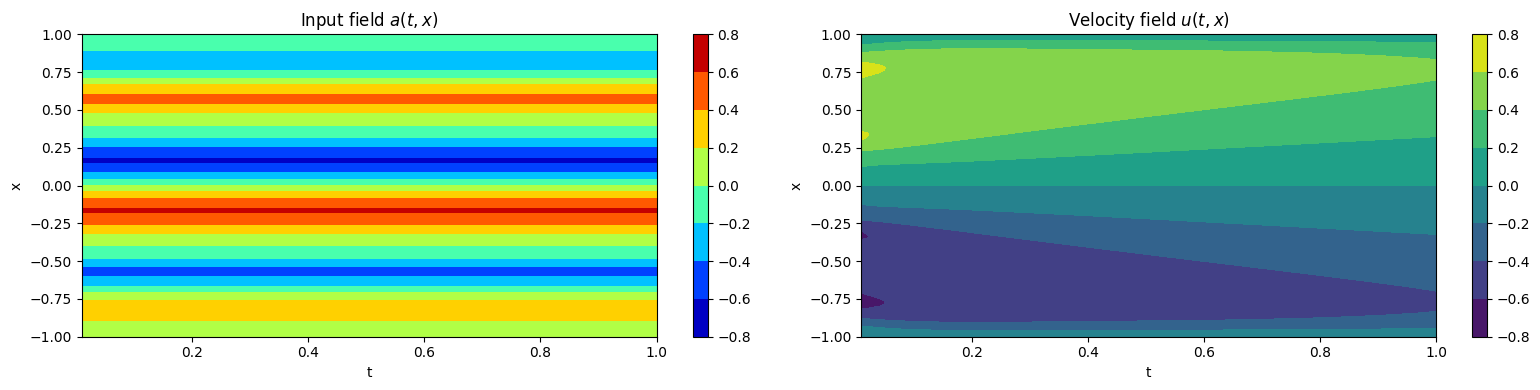

In [10]:
# Get training data
a_train, u_train, a_test, u_test, x, T, X = get_train_data(dtype)
a_train, a_test = transform_data(a_train, a_test, T)

print('The shape of X:', x.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)

# Plot one case
a_show, u_show = a_test[0], u_train[0]
plot_case(a_show, u_show, X, T)

#### Training the model

In [11]:
# Define hiperparams
hiperparms = {'layers_branch': [a_train.shape[-1], 128, 128, 128, 128], 'layers_trunk': [x.shape[-1], 128, 128, 128, 128], 
              'epochs':2000, 'batch_size':50, 'patience':200, 'lr': 1e-3, 'weight_decay': 1e-3, 'step_size_divider': 4, 'gamma': 0.5}

In [12]:
# Get solver and train
solver = SolverDeepONet(x, a_train, u_train, a_test, u_test, DeepONet, LossClass, torch.optim.Adam, torch.optim.lr_scheduler.StepLR, hiperparms, device)
solver.train()

  0%|          | 2/2000 [00:00<07:29,  4.44it/s]

[1/2000] Train Loss: 24.072046 | Test Loss: 21.073616 | Rel L2: 0.784896 | LR: 1.00e-03


  5%|▌         | 101/2000 [00:12<03:43,  8.49it/s]

[100/2000] Train Loss: 3.858688 | Test Loss: 4.022530 | Rel L2: 0.157386 | LR: 1.00e-03


 10%|█         | 201/2000 [00:23<03:33,  8.43it/s]

[200/2000] Train Loss: 2.915012 | Test Loss: 2.734537 | Rel L2: 0.109814 | LR: 1.00e-03


 15%|█▌        | 301/2000 [00:35<03:19,  8.54it/s]

[300/2000] Train Loss: 2.465403 | Test Loss: 2.379840 | Rel L2: 0.096358 | LR: 1.00e-03


 20%|██        | 401/2000 [00:47<03:08,  8.49it/s]

[400/2000] Train Loss: 2.298997 | Test Loss: 2.379954 | Rel L2: 0.097876 | LR: 1.00e-03


 25%|██▌       | 501/2000 [00:59<02:54,  8.58it/s]

[500/2000] Train Loss: 2.063985 | Test Loss: 2.070475 | Rel L2: 0.083678 | LR: 5.00e-04


 30%|███       | 601/2000 [01:11<02:44,  8.52it/s]

[600/2000] Train Loss: 1.823879 | Test Loss: 1.828420 | Rel L2: 0.074208 | LR: 5.00e-04


 35%|███▌      | 701/2000 [01:23<02:31,  8.58it/s]

[700/2000] Train Loss: 1.796028 | Test Loss: 1.860133 | Rel L2: 0.076508 | LR: 5.00e-04


 40%|████      | 801/2000 [01:34<02:23,  8.37it/s]

[800/2000] Train Loss: 1.739312 | Test Loss: 1.705698 | Rel L2: 0.068865 | LR: 5.00e-04


 45%|████▌     | 901/2000 [01:47<02:08,  8.56it/s]

[900/2000] Train Loss: 1.814436 | Test Loss: 1.768655 | Rel L2: 0.073096 | LR: 5.00e-04


 50%|█████     | 1001/2000 [01:58<01:55,  8.64it/s]

[1000/2000] Train Loss: 1.709505 | Test Loss: 1.657329 | Rel L2: 0.067645 | LR: 2.50e-04


 55%|█████▌    | 1101/2000 [02:10<01:44,  8.64it/s]

[1100/2000] Train Loss: 1.576290 | Test Loss: 1.528443 | Rel L2: 0.061681 | LR: 2.50e-04


 60%|██████    | 1201/2000 [02:22<01:32,  8.62it/s]

[1200/2000] Train Loss: 1.547403 | Test Loss: 1.519630 | Rel L2: 0.061214 | LR: 2.50e-04


 65%|██████▌   | 1301/2000 [02:34<01:25,  8.15it/s]

[1300/2000] Train Loss: 1.507085 | Test Loss: 1.497495 | Rel L2: 0.060449 | LR: 2.50e-04


 70%|███████   | 1401/2000 [02:46<01:28,  6.79it/s]

[1400/2000] Train Loss: 1.478043 | Test Loss: 1.432191 | Rel L2: 0.057470 | LR: 2.50e-04


 75%|███████▌  | 1501/2000 [02:59<00:58,  8.60it/s]

[1500/2000] Train Loss: 1.493042 | Test Loss: 1.466540 | Rel L2: 0.059447 | LR: 1.25e-04


 80%|████████  | 1601/2000 [03:11<00:47,  8.38it/s]

[1600/2000] Train Loss: 1.414779 | Test Loss: 1.382946 | Rel L2: 0.055253 | LR: 1.25e-04


 85%|████████▌ | 1701/2000 [03:24<00:36,  8.29it/s]

[1700/2000] Train Loss: 1.402217 | Test Loss: 1.365000 | Rel L2: 0.054508 | LR: 1.25e-04


 90%|█████████ | 1801/2000 [03:36<00:24,  8.05it/s]

[1800/2000] Train Loss: 1.385619 | Test Loss: 1.356026 | Rel L2: 0.054308 | LR: 1.25e-04


 95%|█████████▌| 1901/2000 [03:48<00:12,  8.19it/s]

[1900/2000] Train Loss: 1.379506 | Test Loss: 1.353231 | Rel L2: 0.054145 | LR: 1.25e-04


100%|██████████| 2000/2000 [04:01<00:00,  8.29it/s]

[2000/2000] Train Loss: 1.343666 | Test Loss: 1.317905 | Rel L2: 0.053008 | LR: 6.25e-05
The consuming time is: 242.57075309753418


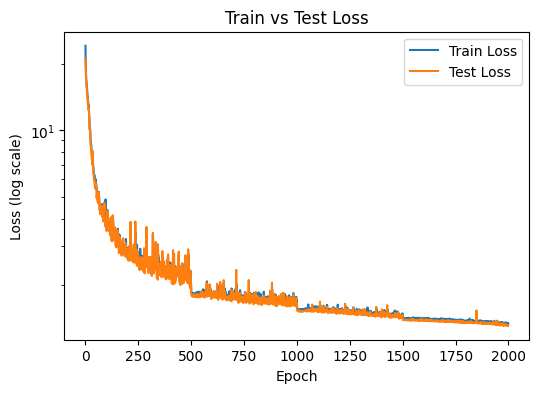

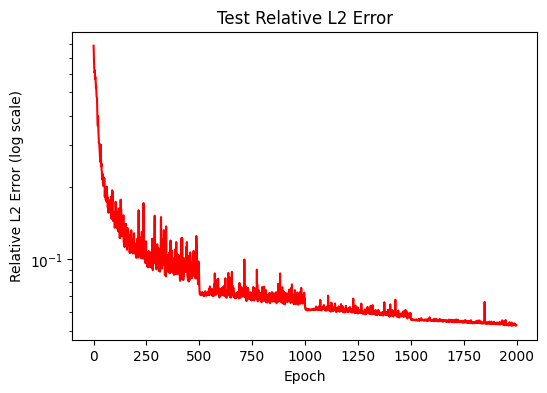

In [13]:
solver.plot_training_results(save=True)

#### Saving the model

In [14]:
solver.save_best_model()

#### Plotting the results

The test l2 error in the test whole dataset: 0.05300760269165039
The test l2 error in the test case 0: 0.1046847477555275


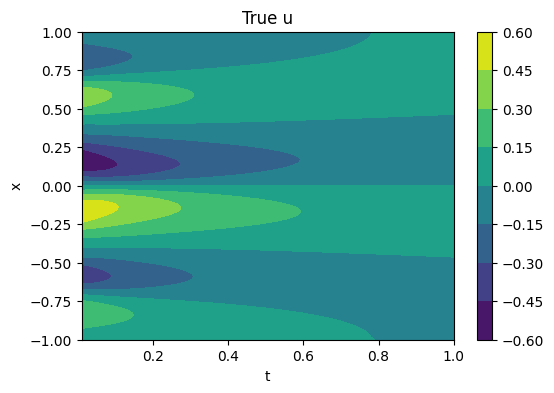

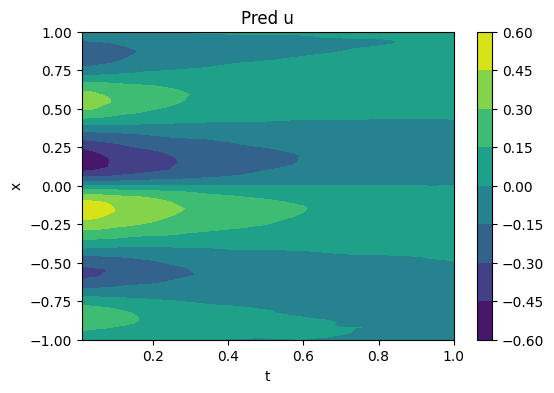

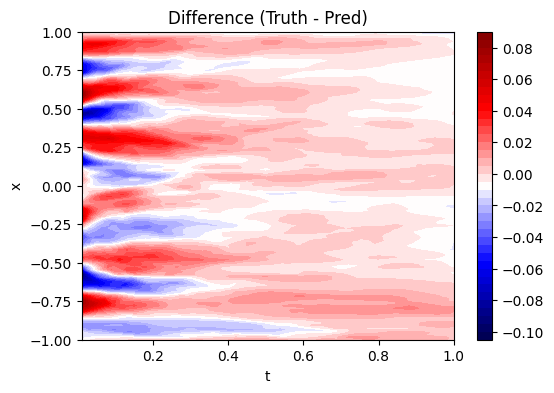

In [15]:
plot_results(hiperparms, case_indx=0, save=True)